# Data Explorer via Contextual AI

This tutorial demonstrats how to explorer different types of data using `xai.data.explorer`. 

We have supported the following types of data:
 - Categorical
 - Numerical
 - Free Text
 - Datetime

In [1]:
# Some auxiliary imports for the tutorial
import sys
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import datasets
sys.path.append('../../')
import xai

/Users/i309943/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We use the following datasets as samples to demonstrate the above analyzers:
 - [Breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer): demonstration for `xai.data.explorer.categorical`
 - [Iris plants dataset](https://scikit-learn.org/stable/datasets/index.html#iris-plants-dataset): demonstration for `xai.data.explorer.numerical`
 - [The 20 newsgroups text dataset](https://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset): demonstration for `xai.data.explorer.text`
 - Self-generated dataset: demonstration for `xai.data.explorer.datetime`

## 1. Categorical
Package `xai.data.explorer.categorical` analyzes categorical datasets and produces a frequency count for each categorical value. `categorical_analyzer` can feed in categorical values and return a `categorical_stats` object, which contains frequency count for each unique value. `labelled_categorical_analyzer` takes an additional argument *class* when fed values, and it generates frequency counts by class type.

In [2]:
# load dataset
cols_names = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 
              'deg-malig', 'breast', 'breast-quad', 'irradiat']
# read the data
breast_data = pd.read_csv('sample_data/breast-cancer.data', header=None, 
                 names=cols_names).replace({'?': 'unknown'})  # NaN are represented by '?'

breast_data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [3]:
from xai.data.explorer.categorical.labelled_categorical_analyzer import LabelledCategoricalDataAnalyzer

First, we analyze *breast-quad* column based on *Class*. The frequency count for each breast-quad is summarized per class type, as shown in the figure on the left. `labelled_categorical_analyzer` also generates a combined frequency counts across all classes, as shown in the figure on the right.

In [4]:
label_column = 'Class'
feature_column = 'breast-quad'
labelled_analyzer = LabelledCategoricalDataAnalyzer()
labelled_analyzer.feed_all(breast_data[feature_column].tolist(),breast_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics()

We define a helper class `xai.plots.NotebookPlots` to help visualize generated statistics.

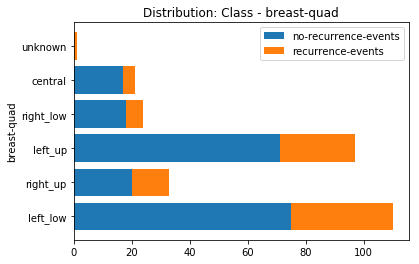

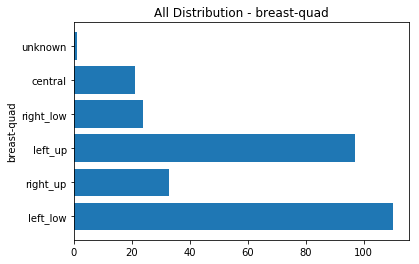

In [5]:
from xai.plots.data_stats_notebook_plots import NotebookPlots
plotter = NotebookPlots()
plotter.plot_labelled_categorical_stats(labelled_stats, all_stats, label_column, feature_column)

Similarly, we can analyze *breast-quad* column but choose *menopause* as class. The frequency count for each breast-quad is summarized per menopause type.

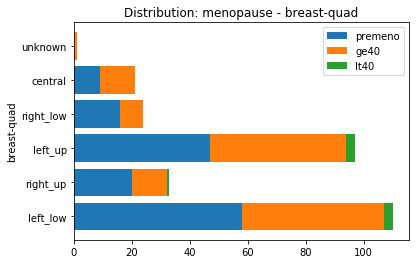

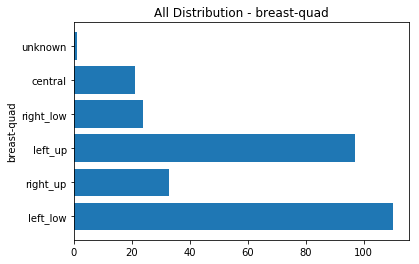

In [6]:
label_column = 'menopause'
feature_column = 'breast-quad'
labelled_analyzer = LabelledCategoricalDataAnalyzer()
labelled_analyzer.feed_all(breast_data[feature_column].tolist(),breast_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics()
plotter.plot_labelled_categorical_stats(labelled_stats, all_stats, label_column, feature_column)

## 2. Numerical

Package `xai.data.explorer.numerical` analyzes numerical datasets and produces statistics analysis including *min*, *max*, *mean*, *median*, *sd*, *histogram* and *kde*. `numerical_analyzer` takes all inputted numerical values and generates an overall analysis, while `labelled_numerical_analyzer` takes numerical values and class labels to generate analysis per class type.

In [7]:
# load dataset
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris.data,columns=iris.feature_names)
iris_data['Class'] = iris.target
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
from xai.data.explorer.numerical.labelled_numerical_analyzer import LabelledNumericalDataAnalyzer

First, we show statistics of *sepal width (cm)* with respect to *Class*.

### sepal width (cm)

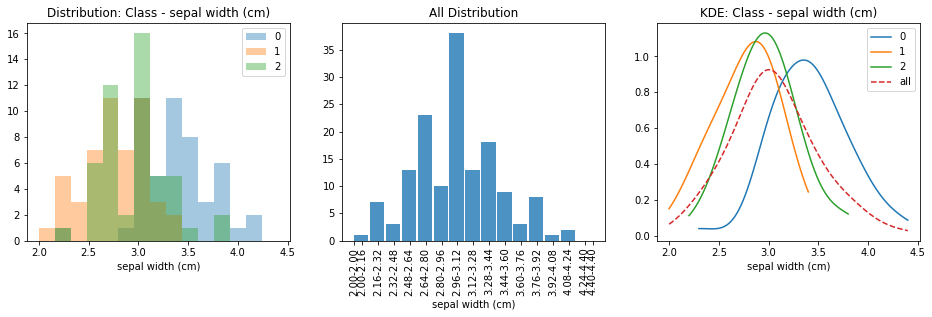

,class,max,mean,median,min,sd,total_count
0,0,4.4,3.418,0.377195,2.3,4.4,50
1,1,3.4,2.770,0.310644,2.0,3.4,50
2,2,3.8,2.974,0.319255,2.2,3.8,50
3,all,4.4,3.054,0.432147,2.0,4.4,150


In [9]:
label_column = 'Class'
feature_column = 'sepal width (cm)'
labelled_analyzer = LabelledNumericalDataAnalyzer()
labelled_analyzer.feed_all(iris_data[feature_column].tolist(),iris_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics(extreme_value_percentile=[0,100],num_of_bins=15)

plotter.plot_labelled_numerical_stats(labelled_stats,all_stats,label_column,feature_column)

Here is another example of statistics of *petal length (cm)* with respect to *Class*.

### petal length (cm)

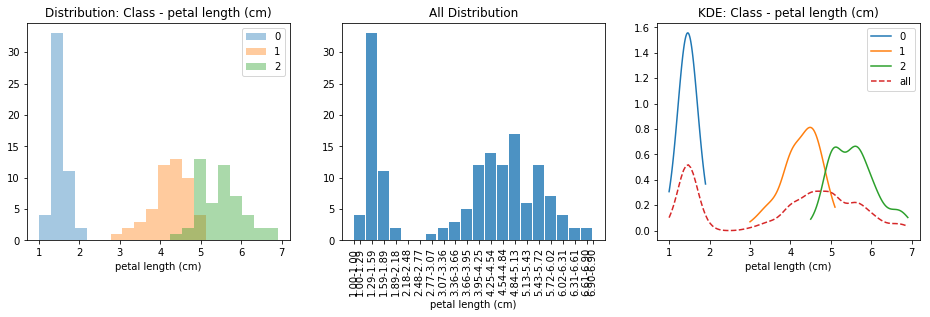

,class,max,mean,median,min,sd,total_count
0,0,1.9,1.464000,0.171767,1.0,1.9,50
1,1,5.1,4.260000,0.465188,3.0,5.1,50
2,2,6.9,5.552000,0.546348,4.5,6.9,50
3,all,6.9,3.758667,1.758529,1.0,6.9,150


In [10]:
label_column = 'Class'
feature_column = 'petal length (cm)'
labelled_analyzer = LabelledNumericalDataAnalyzer()
labelled_analyzer.feed_all(iris_data[feature_column].tolist(),iris_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics(extreme_value_percentile=[0,100],num_of_bins=20)

plotter.plot_labelled_numerical_stats(labelled_stats,all_stats,label_column,feature_column)

## 3. Text

Package `xai.data.explorer.text` analyzes free text datasets and produces statistics analysis including *word count*, *character count*, *term frequency*, *document frequency* and *tfidf*. `text_analyzer` takes all inputted free text and generates an overall analysis, while `labelled_text_analyzer` takes free text and associated class labels to generate statistical analysis per class type.

In [11]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
sample_num = 2000
texts = data['data'][:sample_num]
labels = [data['target_names'][i] for i in data['target']][:sample_num]

We allow user to define the preprocessing function and some predefined pattern.

In [12]:
from xai.data.explorer.text.labelled_text_analyzer import LabelledTextDataAnalyzer

def preprocess(text):
    import re
    text = re.sub(r'[^\w\s]',' ',text)
    return text

predefined_pattern = {'point':r'p\d','number':r'\d+','singlar':r'\s\w\s'}

First, we show tfidf and term frequency by class type. Then we show tfidf and term frequency across all classes. 

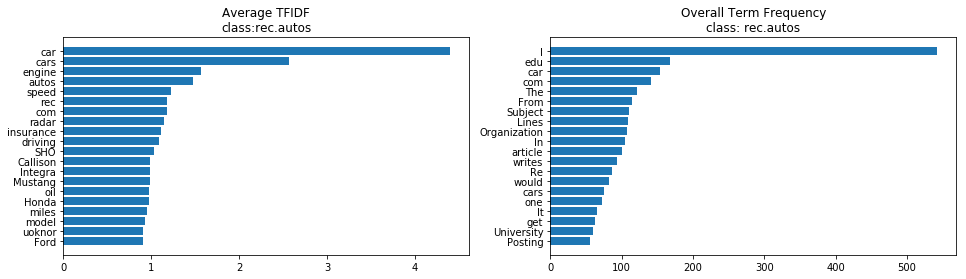

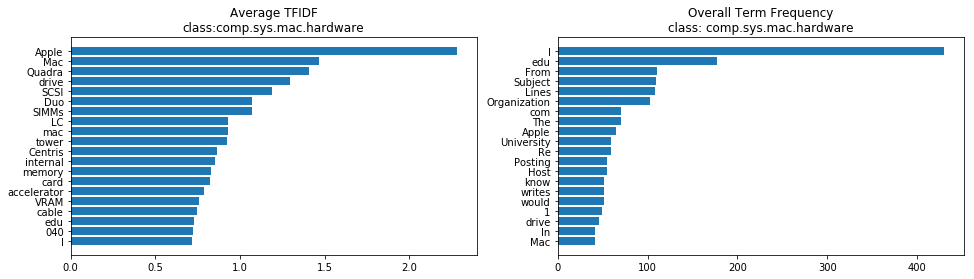

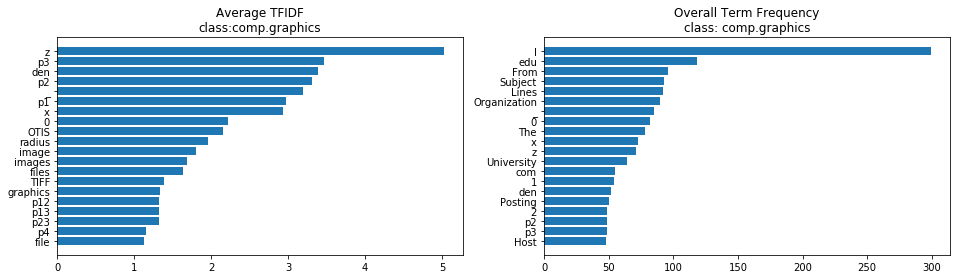

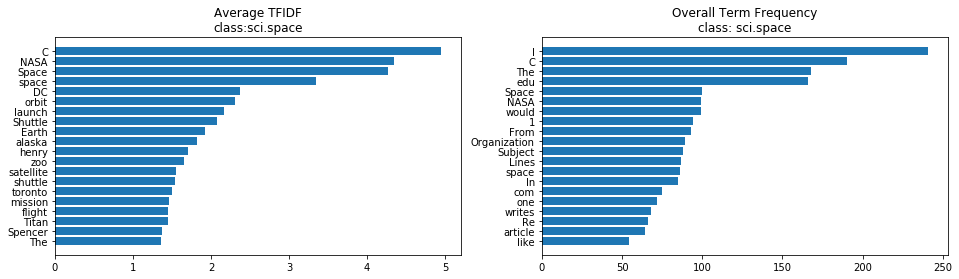

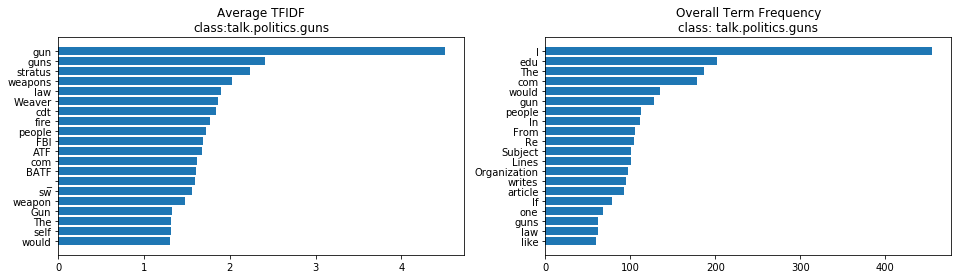

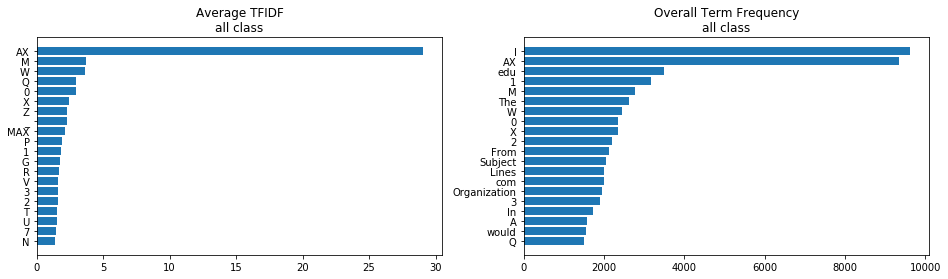

,class,longest doc,number (doc count),number (term count),point (doc count),point (term count),singlar (doc count),singlar (term count),total count
0,rec.autos,1963,109,1748,2,2,109,2019,109
1,comp.sys.mac.hardware,566,108,1132,4,5,108,1324,108
2,comp.graphics,1595,92,1277,4,207,92,1632,92
3,sci.space,3782,87,1799,0,0,87,1794,87
4,talk.politics.guns,2552,100,1022,4,4,100,1924,100
5,all,15769,2000,69203,46,264,1997,62943,2000


In [13]:
labelled_analyzer = LabelledTextDataAnalyzer(preprocess_fn=preprocess,stop_words_by_languages=['english'],
                                             predefined_pattern=predefined_pattern)
labelled_analyzer.feed_all(texts,labels)
labelled_stats, all_stats = labelled_analyzer.get_statistics()
plotter.plot_labelled_text_stats(labelled_stats, all_stats)


## 4. Datetime

Package `xai.data.explorer.datetime` analyzes date time datasets and produces frequency counts for a given resolution, which can be *year*, *month*, *day*, *weekday*, *hour*, *minute*, or *second*. `datetime_analyzer` takes all values and generates an overall analysis, while `labelled_datetime_analyzer` generates statistical analysis per class type.

In [14]:
filename = 'sample_data/date.csv'
data = pd.read_csv(filename)
data.head()


,COMPANYCODE,POSTINGDATE,VALUEDATE
0,13,20180309,20180309
1,13,20180223,20180223
2,13,20180223,20180223
3,13,20180223,20180223
4,13,20180227,20180227


In [15]:
from xai.data.explorer.datetime.labelled_datetime_analyzer import LabelledDatetimeDataAnalyzer
from xai.data.constants import DatetimeResolution

We set the resolution to be *year* and *month*, so that input data will be grouped by their year and month.

In [16]:
datetime_column = 'POSTINGDATE'
label_column = 'COMPANYCODE'
datetimes = [int(x) for x in data[datetime_column]]
labels =[int(x) for x in data[label_column]]

labelled_analyzer = LabelledDatetimeDataAnalyzer()
labelled_analyzer.feed_all(datetimes,labels)
labelled_stats, all_stats = labelled_analyzer.get_statistics(resolution_list=[DatetimeResolution.YEAR,
                                                                               DatetimeResolution.MONTH])

We define a helper function `plot_labelled_datetime_stats` to help visualize generated statistics. This function is only valid to plot datatime distribution with resolution *YEAR* and *MONTH*. 

In [17]:
import matplotlib.pyplot as plt
def plot_labelled_datetime_stats(labelled_stats, all_stats, label_name):     
    def _plot(_class,_frequency_count):
        plt.figure(figsize=(8,4))
        data_dist = {k: v for (k, v) in sorted(_frequency_count.items())}
        min_year = list(data_dist.keys())[0]
        max_year = list(data_dist.keys())[-1]

        earliest = (min_year, min([int(month) for month in data_dist[min_year].keys()]))
        latest = (max_year, max([int(month) for month in data_dist[max_year].keys()]))

        line_num = len(data_dist)
        data_frame = []
        for year in data_dist:
            year_data = [0] * 13
            year_data[0] = year
            for month in data_dist[year]:
                year_data[int(month)] = int(data_dist[year][month])
            data_frame.append(year_data)
        data_frame = np.array(data_frame).astype(int)
        bars = []
        colors = ['#1abc9c', '#2ecc71', '#3498db', '#7f8c8d', '#9b59b6', '#34495e', '#f1c40f', '#e67e22', '#e74c3c',
                  '#95a5a6', '#d35400', '#bdc3c7']
        legends = ['Jan', 'Feb', 'Mar', 'April', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        current_sum = np.zeros(line_num)
        for month in range(1, 13):
            p = plt.barh(y=list(range(0, line_num)), width=data_frame[:, month].tolist(), left=current_sum.tolist(),
                         color=colors[month - 1])
            bars.append(p)
            current_sum = data_frame[:, month] + current_sum
        for idx in range(line_num):
            plt.text(current_sum[idx], idx, int(current_sum[idx]), color='black', ha="left")

        plt.yticks(list(range(0, line_num)), list(data_dist.keys()))
        plt.legend(bars, legends, bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.title(
            '%s - %s\nDate Range: %s.%s - %s.%s' % (label_name,_class,earliest[0], legends[earliest[1] - 1], latest[0], legends[latest[1] - 1]))
        plt.show()
    
    for _class in list(labelled_stats.keys())[:3]:
        _plot(_class,labelled_stats[_class].frequency_count)
        
    _plot('all',all_stats.frequency_count)

The figures below show frequency counts by class based on *year* and *month* as configured previsouly.

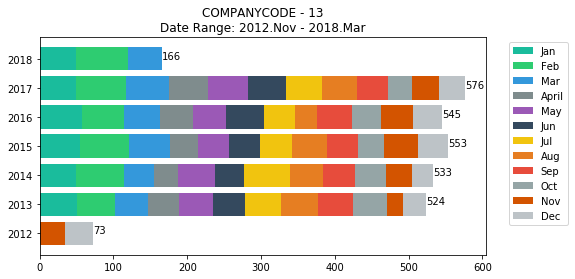

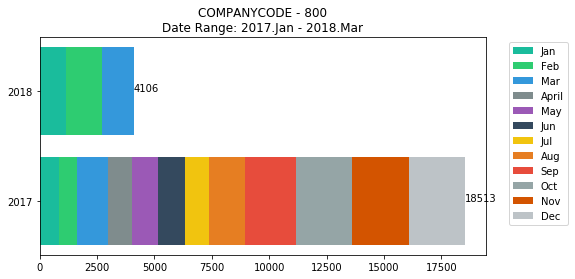

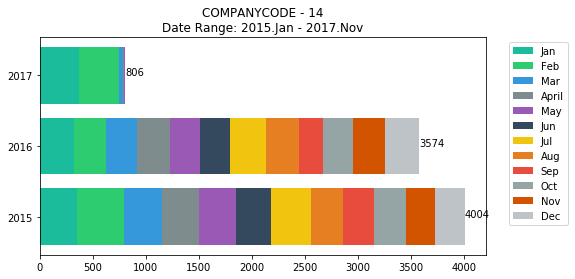

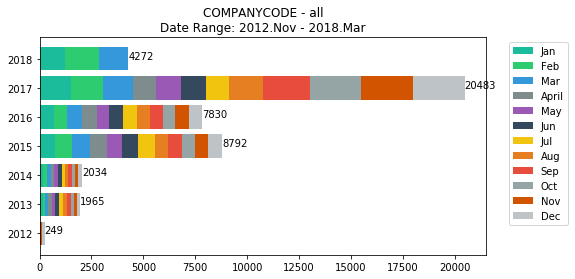

In [18]:
plot_labelled_datetime_stats(labelled_stats, all_stats, label_column)

## 5. Data Analyzer Suite

`xai.data.explorer.DataAnalyzerSuite` is a tool to analyze a data set based on its defined schema. It support structured data (e.g. csv) and unstructured data (e.g. jsonline). It can be compatible to data set with sequence features. 

In [19]:
## load meta data
import json
from pprint import pprint

with open('./sample_data/meta.json','r') as f:
    meta = json.load(f)
    
pprint(meta)

# get feature names, feature types and sequence feature names,
sequence_names = list(meta['sequence'].keys())

data_type = []
column_names = []

for key, value in meta['non_sequence'].items():
    data_type.append(value['type'])
    column_names.append(key)
    
for key, value in meta['sequence'].items():
    data_type.append(value['type'])
    column_names.append(key)

print(sequence_names)
print(column_names)
print(data_type)

{'non_sequence': {'IC_0/COUNTRY': {'type': 'categorical'},
                  'IC_0/REGION': {'type': 'categorical'},
                  'IC_0/SEX': {'type': 'categorical'}},
 'sequence': {'IA_0/COMM_MEDIUM': {'type': 'categorical'},
              'IA_0/IA_INTERVAL': {'type': 'numerical'},
              'IA_0/IA_REASON': {'type': 'categorical'},
              'IA_0/IA_TYPE': {'type': 'categorical'}}}
['IA_0/IA_TYPE', 'IA_0/IA_INTERVAL', 'IA_0/COMM_MEDIUM', 'IA_0/IA_REASON']
['IC_0/COUNTRY', 'IC_0/REGION', 'IC_0/SEX', 'IA_0/IA_TYPE', 'IA_0/IA_INTERVAL', 'IA_0/COMM_MEDIUM', 'IA_0/IA_REASON']
['categorical', 'categorical', 'categorical', 'categorical', 'numerical', 'categorical', 'categorical']


We import `xai.data.explorer.data_analyzer_suite` and initialize an object of `DataAnalyzerSuite`. The initializer takes 3 parameters:
- *data_type_list*: a list of pre-defined data type
- *columns_names*: a list of column name. If this is not provided, the data_type_list should be the same length of the data
- *sequence_names*: a list of feature names which is considered as sequence feature, so that each item of the value will be aggragated to get the overall stats.

In [20]:
from xai.data.explorer.data_analyzer_suite import DataAnalyzerSuite

data_analyzer_suite = DataAnalyzerSuite(data_type_list=data_type, 
                                        column_names=column_names,
                                        sequence_names=sequence_names)

Then we parse each json line of the data into a json object and feed into the analyzer, together with the label.

In [21]:
## load json line data
with open('./sample_data/lead_score.data','r') as f:
    for line in f:
        data = json.loads(line)
        label = data['LABEL']
        data_analyzer_suite.feed_row(data,label)    

Finally the `get_statistics()` function is called to generate the stats of the entire data based on the each column and its type. The returned stats is a dictionary which maps feature name to a tuple of stats (class-based stats and overall stats). 

In [22]:
stats = data_analyzer_suite.get_statistics()
pprint(stats)

{'IA_0/COMM_MEDIUM': ({0: <xai.data.explorer.categorical.categorical_stats.CategoricalStats object at 0x7f83e163bc18>,
                       1: <xai.data.explorer.categorical.categorical_stats.CategoricalStats object at 0x7f83e163b7f0>},
                      <xai.data.explorer.categorical.categorical_stats.CategoricalStats object at 0x7f83e163b438>),
 'IA_0/IA_INTERVAL': ({0: <xai.data.explorer.numerical.numerical_stats.NumericalStats object at 0x7f83e163bba8>,
                       1: <xai.data.explorer.numerical.numerical_stats.NumericalStats object at 0x7f83e163b3c8>},
                      <xai.data.explorer.numerical.numerical_stats.NumericalStats object at 0x7f83e163bf60>),
 'IA_0/IA_REASON': ({0: <xai.data.explorer.categorical.categorical_stats.CategoricalStats object at 0x7f83e163bcf8>,
                     1: <xai.data.explorer.categorical.categorical_stats.CategoricalStats object at 0x7f83e163beb8>},
                    <xai.data.explorer.categorical.categorical_stats.Cate

We plot `IA_0/COMM_MEDIUM` as an example for categorical features results, and `IA_0/IA_INTERVAL` as the numerical restuls.

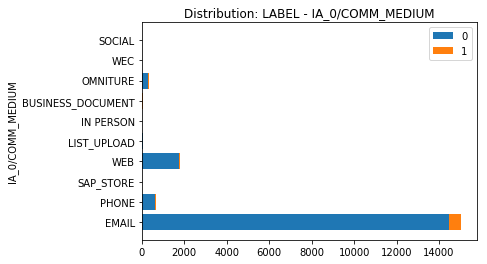

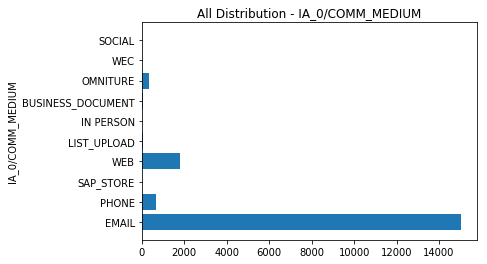

In [23]:
feature_column = 'IA_0/COMM_MEDIUM'
plotter.plot_labelled_categorical_stats(labelled_stats = stats[feature_column][0],
                                        all_stats = stats[feature_column][1], 
                                        label_column = 'LABEL',
                                        feature_column = feature_column)

### IA_0/IA_INTERVAL

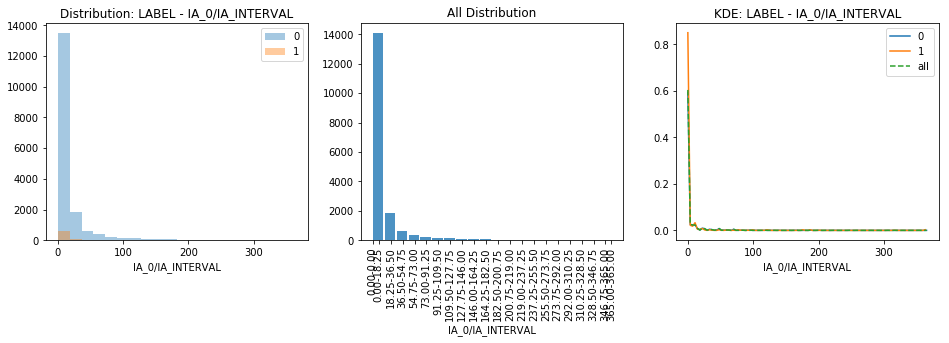

,class,max,mean,median,min,sd,total_count
0,0,365.0,18.147545,41.756111,0.0,365.0,17249
1,1,363.0,18.162088,46.937193,0.0,363.0,728
2,all,365.0,18.148134,41.978351,0.0,365.0,17977


In [24]:
feature_column = 'IA_0/IA_INTERVAL'
plotter.plot_labelled_numerical_stats(labelled_stats = stats[feature_column][0],
                                      all_stats = stats[feature_column][1], 
                                      label_column = 'LABEL',
                                      feature_column = feature_column)